In [4]:
# define imports 
import os
import random
import pickle
import shutil
import ast
import numpy as np
import pandas as pd
import scipy as sc
from statsmodels.sandbox.stats.multicomp import multipletests

# import plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
# seed the global RNG 
random.seed(SEED)
# seed the global NumPy RNG
np.random.seed(SEED)

#### Term enrichment analysis

In [5]:
def run_enrichment_analysis(ann_df, keys, filename, alpha=.05, seed=SEED): 

    """This function performs enrichment analysis with Fisher's exact test 
    for a list of terms.

    :param ann_df: annotation dataframe of (n_samples, n_terms) with samples as index 
    :param keys: inchikeys of molecules of interest 
    :param filename: name of output file
    :param alpha: threshold for statistical significance
    :param seed: seed for reproducibility 
    :return: dictionary having terms as keys and computed statistics as values 
    """
    
    # seed the global RNG 
    random.seed(seed)
    # seed the global NumPy RNG
    np.random.seed(seed)
    
    # inizialize variables
    statistics = {}
    term_statistics = {}
    pvals = []
    
    for term in ann_df.columns:
        # get molecules of interest that are annotated with that term 
        int_mol_ann = np.count_nonzero(
            ann_df.loc[ann_df.index.isin(list(keys))].loc[:,term])
        # check if molecules of interest are at least 5 for robustness
        if int_mol_ann >= 5:
            statistics[term] = dict()
            # get overlapping molecules 
            overlap_mol = len(set(ann_df.index) & set(keys))  
            # bg molecules that are annotated with that term 
            # (excluded molecules of interest) 
            bg_mol_ann = np.count_nonzero(ann_df.loc[:,term]) - int_mol_ann
            # molecules of interest that are not annotated with that term
            int_mol_no_ann =  overlap_mol - int_mol_ann 
            # bg molecules that are not annotated with that term 
            # (excluded molecules of interest)
            bg_mol_no_ann = len(ann_df) - overlap_mol - bg_mol_ann
            # construct contingency table 
            contingency_table = pd.DataFrame([[int_mol_ann, bg_mol_ann], 
                                              [int_mol_no_ann, bg_mol_no_ann]], 
                                              index=["term", "not_term"], 
                                              columns=["int_molecules", "bg_molecules"])

            # compute statistics 
            oddsratio, pval = sc.stats.fisher_exact(contingency_table, 
                                                    alternative='greater')   
            pvals.append(pval)
            # save term statistics 
            statistics[term]['contingency_matrix'] = contingency_table
            statistics[term]['odds_ratio'] = oddsratio
            statistics[term]['pvalue'] = pval

    # apply Bonferroni correction  
    adj_stats = multipletests(pvals, 
                              alpha=alpha, 
                              method='bonferroni')

    # get enriched terms and the corresponding adjusted p-values filtering by odds ratio 
    enriched_terms = [(i, k) for i, k in enumerate(statistics.keys()) if adj_stats[0][i]]
    for idx, term in enriched_terms: 
        term_statistics[term] = statistics[term]
        term_statistics[term]['adj_pval'] = adj_stats[1][idx]
    
    # save results 
    f = open(filename, "wb")  
    # dump dictionary
    pickle.dump(term_statistics, f)      
    f.close()   
    
    return term_statistics

In [60]:
# define paths
tables_path = "../tables"
output_path = "../tmp"
# remove temporary folder if it exists
if os.path.exists(output_path): shutil.rmtree(output_path)
os.mkdir(output_path)

In [73]:
# load CC Molset dataset to visualize annotations
molset_cc = pd.read_csv(tables_path + '/Molset_CC_B2_B4_annotated.csv.zip')
molset_cc

,InChIKey,SMILES,B2_features,B4_features
0,AAAAEENPAALFRN-UHFFFAOYSA-N,COc1c(I)cc(Oc2c[nH]c(=NCCS(C)(=O)=O)[nH]c2=N)c...,[],"['Class:1005', 'Class:1024', 'Class:1047', 'P4..."
1,AAAAZQPHATYWOK-JXMROGBWSA-N,CCOc1cc2[nH]cc(C#N)c(=Nc3ccc(OCc4nc5ccccc5s4)c...,[],"['Class:1', 'Class:1100', 'Class:1285', 'Class..."
2,AAABHMIRDIOYOK-UHFFFAOYSA-N,Cn1cc([N+](=O)[O-])c(C(=O)Nc2cc3c(cc2)nc(-c2cc...,[],[]
3,AAABMNXUOFPYQK-GRMLSQNXSA-N,C=C1C[C@](OC)([C@H](O)C(=O)N[C@H]2OCO[C@H]3[C@...,[],[]
4,AAABTPAECTZDET-UHFFFAOYSA-N,Cc1c(Nc2cc(N3CCOCC3)nc(-n3cnc4ccccc43)n2)cc(O)cc1,[],"['Class:1', 'Class:1100', 'Class:1285', 'Class..."
...,...,...,...,...
1009287,ZZZYFYOJEILVNN-UHFFFAOYSA-N,CCCOC(=O)c1nn(C(=O)c2cscc2)c2ccccc12,[],"['Class:1', 'Class:1028', 'Class:1079', 'Class..."
1009288,ZZZYHIMVKOHVIH-MWFXHRFLSA-N,COC(=O)[C@]12OC[C@]34[C@H]([C@@H](O)[C@@H]1O)[...,[],[]
1009289,ZZZYHIMVKOHVIH-UHFFFAOYSA-N,COC(=O)C12OCC34C(CC5C(C)=C(O)C(=O)CC5(C)C3C(O)...,[],"['Class:1033', 'Class:1042', 'Class:1164', 'Cl..."
1009290,ZZZYHIMVKOHVIH-VILODJCFSA-N,COC(=O)[C@@]12OC[C@]34[C@H]([C@@H](O)[C@@H]1O)...,[],"['Class:12', 'Q16236']"


In [62]:
# visualize CC spaces 
molset_cc.columns

Index(['InChIKey', 'SMILES', 'B2_features', 'B4_features'], dtype='object')

In [63]:
# load APDB molecules 
ap_molecules = pd.read_csv(tables_path + '/MoleculesTable.csv', encoding='latin1')
ap_smiles = ap_molecules["Canonical_SMILES"].to_list()
ap_inchikeys = ap_molecules["InChIKey"].to_list()
print("Number of SMILES is " + str(len(ap_smiles)))

Number of SMILES is 1830


In [64]:
# load APDB Molset dataset to visualize annotations
molset_ap = pd.read_csv(tables_path + '/Molset_APDB_annotated.csv', index_col=0)
molset_ap

,InChIKey,InChI,SMILES,APDB_SMILES,Scaffold,B1,B1_features,B2,B2_features,B3,...,E1,E1_features,E2,E2_features,E3,E3_features,E4,E4_features,E5,E5_features
0,AABTWRKUKUPMJG-UHFFFAOYSA-N,"InChI=1S/C6H8O/c1-5-3-6(2)7-4-5/h3-4H,1-2H3",Cc1coc(C)c1,CC1=CC(=CO1)C,c1ccoc1,0,[],0,[],0,...,0,[],0,[],0,[],0,[],0,[]
1,AADQFNAACHHRLT-UHFFFAOYSA-N,InChI=1S/C11H16/c1-8(2)11-6-5-9(3)7-10(11)4/h5...,Cc1cc(C)c(C(C)C)cc1,CC1=CC(=C(C=C1)C(C)C)C,c1ccccc1,0,[],0,[],0,...,0,[],0,[],0,[],0,[],0,[]
2,AAWSGCLXIJBMRM-UHFFFAOYSA-N,InChI=1S/C12H24/c1-4-7-8-9-10-11-12(5-2)6-3/h4...,C=CCCCCCC(CC)CC,CCC(CC)CCCCCC=C,NaN,0,[],0,[],0,...,0,[],0,[],0,[],0,[],0,[]
3,ACWQBUSCFPJUPN-UHFFFAOYSA-N,"InChI=1S/C5H8O/c1-3-5(2)4-6/h3-4H,1-2H3",CC=C(C)C=O,CC=C(C)C=O,NaN,0,[],0,[],0,...,0,[],0,[],0,[],0,[],0,[]
4,ACYHSTUWOQNWCX-UHFFFAOYSA-N,"InChI=1S/C10H22/c1-6-7-8-9(2)10(3,4)5/h9H,6-8H...",CCCCC(C)C(C)(C)C,CCCCC(C)C(C)(C)C,NaN,0,[],0,[],0,...,0,[],0,[],0,[],0,[],0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,ZXLUFQJSMQSMTR-UHFFFAOYSA-N,"InChI=1S/C8H14/c1-4-5-6-7-8(2)3/h5-7H,4H2,1-3H3",CCC=CC=C(C)C,CCC=CC=C(C)C,NaN,0,[],0,[],0,...,0,[],0,[],0,[],0,[],0,[]
1826,ZXVONLUNISGICL-UHFFFAOYSA-N,InChI=1S/C7H6N2O5/c1-4-2-5(8(11)12)3-6(7(4)10)...,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,CC1=CC(=CC(=C1O)[N+](=O)[O-])[N+](=O)[O-],c1ccccc1,0,[],0,[],0,...,0,[],0,[],0,[],0,[],0,[]
1827,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,InChI=1S/C9H6O2/c10-9-6-5-7-3-1-2-4-8(7)11-9/h...,O=c1ccc2ccccc2o1,C1=CC=C2C(=C1)C=CC(=O)O2,O=c1ccc2ccccc2o1,0,[],0,[],1,...,0,[],0,[],0,[],1,"['D001649(M)', 'D001660(M)', 'D002318(M)', 'D0...",0,[]
1828,ZYURHZPYMFLWSH-UHFFFAOYSA-N,InChI=1S/C28H58/c1-3-5-7-9-11-13-15-17-19-21-2...,CCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCC,NaN,0,[],0,[],0,...,0,[],0,[],0,[],1,"['D008546(T)', 'D009369(T)', 'D009374(T)']",0,[]


In [65]:
# check if keys are the same of APDB 
list(molset_ap.InChIKey) == list(np.sort(ap_inchikeys))

True

In [66]:
# check intersection between ap and cc molecules 
len(set(molset_ap.InChIKey).intersection(set(molset_cc.InChIKey)))

921

In [15]:
# plot the number of APDB molecules having annotation in each CC space 
ann = dict() 
for space in [(a+i) for a in 'BCDE' for i in '12345']:
        # count the number of molecules having features for each space 
        if (any(molset_ap.columns == space + '_features')):
                feats = molset_ap[space + '_features'].apply(ast.literal_eval).explode()
                ann[space] = feats[~feats.isna()].index.unique().shape[0]

# store counts 
ann_counts = pd.DataFrame(data = {"CC space" : ann.keys(), "Counts" : ann.values()})
ann_counts

,CC space,Counts
0,B1,26
1,B2,44
2,B3,309
3,B4,146
4,B5,266
5,C1,630
6,C2,108
7,C3,125
8,C4,125
9,C5,129


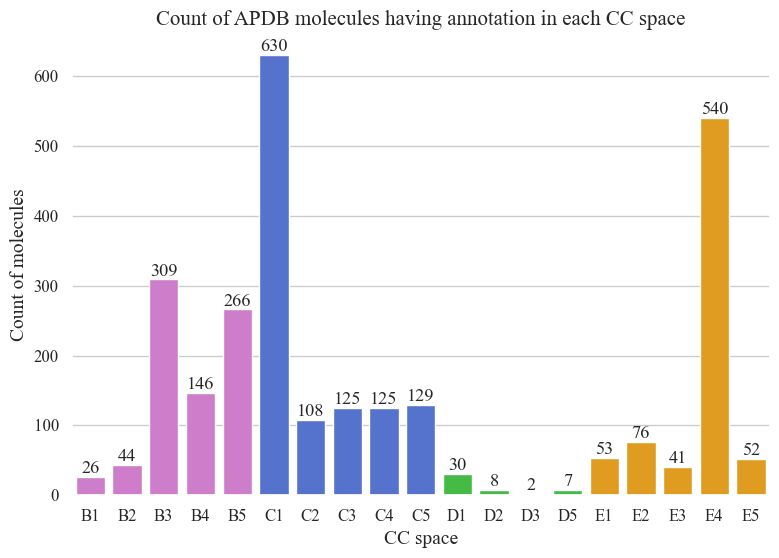

In [12]:
# plot annotation counts 
fig = plt.figure(figsize=(9, 6))
sns.set(font_scale=1.1)
sns.set_style({'axes.facecolor' : 'white', 'grid.color' : '.8', 
               'font.family' : 'Times New Roman'})

# add space color
space_color = ["orchid"]*5
space_color.extend(["royalblue"]*5)
space_color.extend(["limegreen"]*4)
space_color.extend(["orange"]*5)
space_color

ax = sns.barplot(data = ann_counts, 
            y = 'Counts', 
            x = 'CC space',
            palette = space_color)
for bars in ax.containers:
    ax.bar_label(bars)
plt.xlabel("CC space", size=14)
plt.ylabel("Count of molecules", size=14)
plt.title("Count of APDB molecules having annotation in each CC space", size=15)
fig.savefig(output_path + '/APDB_annotation_count.png', dpi=600)
plt.show()

#### B2 - Metabolic genes

In [67]:
# B2 space
B2_features = molset_cc.B2_features.apply(ast.literal_eval).explode()
# remove missing values 
B2_features = B2_features[~B2_features.isna()]
B2_features

641           Class:1
641        Class:1006
641        Class:1027
641        Class:1031
641        Class:1054
              ...    
1009000        P11712
1009000        P20813
1009000        P23219
1009000        P33260
1009000        P33261
Name: B2_features, Length: 20793, dtype: object

In [68]:
# get inchikeys corresponding to index
inchikeys = molset_cc.iloc[B2_features.index].InChIKey	
print(len(inchikeys))

20793


In [69]:
# create dataset for B2 space 
B2_dataset = pd.DataFrame(0, index=inchikeys.unique(), columns=B2_features.unique())
B2_pairs = set(zip(inchikeys, B2_features))
for pairs in B2_pairs:
    # set positive pairs 
    B2_dataset.loc[pairs] = 1
B2_dataset

,Class:1,Class:1006,Class:1027,Class:1031,Class:1054,Class:1055,Class:1056,Class:1104,Class:1132,Class:1179,...,Class:929,P18405,P31645,Class:1071,Class:1220,Class:226,P05093,P00813,P23975,P36021
AAKJLRGGTJKAMG-UHFFFAOYSA-N,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
AAOVKJBEBIDNHE-UHFFFAOYSA-N,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ACCMWZWAEFYUGZ-UHFFFAOYSA-N,0,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ACGDKVXYNVEAGU-UHFFFAOYSA-N,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACRHBAYQBXXRTO-OAQYLSRUSA-N,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYSCHNVPUOSLNC-BTJKTKAUSA-N,1,0,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ZZHLYYDVIOPZBE-UHFFFAOYSA-N,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZZORFUFYDOWNEF-UHFFFAOYSA-N,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZZUFCTLCJUWOSV-UHFFFAOYSA-N,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# check if number of pairs correspond
B2_dataset.sum().sum()

20793

In [71]:
# check intersection with APDB keys
B2_inchikeys_ap = set(B2_dataset.index).intersection(ap_inchikeys)
len(B2_inchikeys_ap)

44

- Term enrichment analysis for B2 space 

In [33]:
# perform term enrichment analysis
B2_statistics = run_enrichment_analysis(B2_dataset, ap_inchikeys, 
                                        filename=output_path + '/B2_statistics.pkl')
B2_statistics

{'O94956': {'contingency_matrix':           int_molecules  bg_molecules
  term                  7            34
  not_term             37          1566,
  'odds_ratio': 8.713831478537362,
  'pvalue': 6.854517277579497e-05,
  'adj_pval': 0.002399081047152824},
 'Class:704': {'contingency_matrix':           int_molecules  bg_molecules
  term                  8            20
  not_term             36          1580,
  'odds_ratio': 17.555555555555557,
  'pvalue': 2.848989968434778e-07,
  'adj_pval': 9.971464889521723e-06},
 'P53985': {'contingency_matrix':           int_molecules  bg_molecules
  term                  6            18
  not_term             38          1582,
  'odds_ratio': 13.87719298245614,
  'pvalue': 2.435133941828101e-05,
  'adj_pval': 0.0008522968796398354},
 'O15427': {'contingency_matrix':           int_molecules  bg_molecules
  term                  5             6
  not_term             39          1594,
  'odds_ratio': 34.05982905982906,
  'pvalue': 4.473114683940

In [34]:
# check how many APDB molecules have this annotation
B2_dataset[B2_dataset.index.isin(molset_ap.InChIKey)][B2_statistics.keys()].apply(pd.value_counts)

,O94956,Class:704,P53985,O15427
0,37,36,38,39
1,7,8,6,5


In [51]:
# get list of uniprots 
[e for e in list(B2_statistics.keys()) if "Class" not in e]

['O94956', 'P53985', 'O15427']

#### B4 - Binding

In [35]:
# B4 space
B4_features = molset_cc.B4_features.apply(ast.literal_eval).explode()
# remove missing values 
B4_features = B4_features[~B4_features.isna()]
B4_features

0          Class:1005
0          Class:1024
0          Class:1047
0              P49654
0              Q9UBL9
              ...    
1009289        P24468
1009290      Class:12
1009290        Q16236
1009291       Class:8
1009291        P20292
Name: B4_features, Length: 3451484, dtype: object

In [36]:
# get inchikeys corresponding to index
inchikeys = molset_cc.iloc[B4_features.index].InChIKey	
print(len(inchikeys))

3451484


In [37]:
# create dataset for B4 space 
B4_dataset = pd.DataFrame(0, index = inchikeys.unique(), columns = B4_features.unique())
B4_pairs = set(zip(inchikeys, B4_features))
for pairs in B4_pairs:
    # set positive pairs 
    B4_dataset.loc[pairs] = 1
B4_dataset

,Class:1005,Class:1024,Class:1047,P49654,Q9UBL9,Class:1,Class:1100,Class:1285,Class:149,Class:6,...,P29992,P80193,P27471,Q9UP65,Q9BY66,P19332,P62509,P05631,Q9BU89,Q8IDJ8
AAAAEENPAALFRN-UHFFFAOYSA-N,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAAZQPHATYWOK-JXMROGBWSA-N,0,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
AAABTPAECTZDET-UHFFFAOYSA-N,0,0,0,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
AAACBXVBBDAYRQ-UHFFFAOYSA-N,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AAACGYYPWMUUFL-LJQANCHMSA-N,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZZWVADOTWQQFE-VWLOTQADSA-N,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZZZYFYOJEILVNN-UHFFFAOYSA-N,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZZZYHIMVKOHVIH-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZZZYHIMVKOHVIH-VILODJCFSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# check if number of pairs correspond
B4_dataset.sum().sum()

3451484

In [39]:
# check intersection with APDB keys
B4_inchikeys_ap = set(B4_dataset.index).intersection(molset_ap.InChIKey)
len(B4_inchikeys_ap)

146

- Term enrichment analysis for B4 space 

In [44]:
# perform term enrichment analysis 
B4_statistics = run_enrichment_analysis(B4_dataset, ap_inchikeys, 
                                        filename=output_path + '/B4_statistics.pkl')
B4_statistics

{'Class:1': {'contingency_matrix':           int_molecules  bg_molecules
  term                109        332750
  not_term             37        298131,
  'odds_ratio': 2.6394524742623915,
  'pvalue': 4.406131349678998e-08,
  'adj_pval': 2.159004361342709e-06},
 'Class:10': {'contingency_matrix':           int_molecules  bg_molecules
  term                 21         39209
  not_term            125        591672,
  'odds_ratio': 2.5351550919431762,
  'pvalue': 0.0002916422833404816,
  'adj_pval': 0.0142904718836836},
 'Class:1031': {'contingency_matrix':           int_molecules  bg_molecules
  term                 21         10399
  not_term            125        620482,
  'odds_ratio': 10.024134628329648,
  'pvalue': 6.216479282426727e-14,
  'adj_pval': 3.046074848389096e-12},
 'Class:12': {'contingency_matrix':           int_molecules  bg_molecules
  term                 14         22194
  not_term            132        608687,
  'odds_ratio': 2.908791210291616,
  'pvalue': 0.000690

In [45]:
len(B4_statistics.keys())

32

In [46]:
# check how many APDB molecules have this annotation
B4_dataset[B4_dataset.index.isin(molset_ap.InChIKey)][B4_statistics.keys()].apply(pd.value_counts)

,Class:1,Class:10,Class:1031,Class:12,Class:646,P22303,Class:1034,Class:648,O43570,P00915,...,P05177,P21397,Q9NUW8,P07451,P35869,Class:1181,Class:172,P11509,Class:171,P20852
0,37,125,125,132,120,135,128,121,134,135,...,135,139,128,141,134,137,139,139,138,138
1,109,21,21,14,26,11,18,25,12,11,...,11,7,18,5,12,9,7,7,8,8


In [50]:
# get list of uniprots 
[e for e in list(B4_statistics.keys()) if "Class" not in e]

['P22303',
 'O43570',
 'P00915',
 'P00918',
 'Q16790',
 'P22748',
 'P23280',
 'P35218',
 'P43166',
 'Q9ULX7',
 'Q9Y2D0',
 'P05177',
 'P21397',
 'Q9NUW8',
 'P07451',
 'P35869',
 'P11509',
 'P20852']